# Cell phenotyping using a Hierarchical Prior Knowledge Table

In [34]:
# import packages
import scimap as sm
import anndata as ad
import pandas as pd

In [35]:
# Load the data that we saved in the last tutorial - (Prepare data for SCIMAP)
adata = ad.read_h5ad('/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/scimapExampleData.h5ad')

This method requires more work but is significantly more sensitive and scalable compared to clustering-based approaches.

### To run the method, you'll need two main components:

To successfully execute the method, you will need:

1. A `.csv` file containing manual gates. Should manual gates be absent, the algorithm will attempt to adjust the data by fitting two Gaussian distributions. Nonetheless, employing manual gating is recommended due to its heightened sensitivity.
2. A `.csv` file outlining a gating workflow strategy.

The execution of the algorithm is structured into three primary steps:

1. **Gate Identification**: Utilize `sm.pl.gate_finder` to identify the gates.
2. **Data Rescaling**: Apply `sm.pp.rescale` to adjust the data based on the identified gates.
3. **Phenotyping**: Process the rescaled data using `sm.tl.phenotype` to run the phenotyping algorithm.

### Step 1: Define manual gates

In [3]:
%gui qt

This method will launch a napari window displaying several layers, each representing a different gate. You can toggle these layers on and off with the goal of identifying the gate that most accurately captures the positive cells. It's crucial to zoom and pan through the image to ensure the selected gate encompasses all positive cells throughout the image. Bear in mind that achieving 100% accuracy might not be feasible, so a certain margin of error may need to be accepted. This process is iterative, meaning adjustments may be necessary even after initial phenotyping and analysis. Manual gating must be conducted independently for each marker and each image.

In [5]:
image_path = '/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/registration/exemplar-001.ome.tif'
marker_of_interest = 'CD45'

In [6]:
sm.pl.gate_finder (image_path, adata, marker_of_interest, from_gate = 5, to_gate = 9, increment = 0.1, point_size=6)

In [10]:
# Do the above step for each marker and then create a `.csv` file like below:
pd.read_csv('/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/manual_gates.csv')

,marker,exemplar-001--unmicst_cell
0,ELANE,7.80
1,CD57,8.90
2,CD45,6.40
3,CD11B,7.60
4,SMA,7.50
5,CD16,6.50
6,ECAD,7.35
7,FOXP3,7.40
8,NCAM,7.00


You'll observe that the first column lists the markers present in the dataset, while the second column specifies the gate, named after the specific image's ID found in `adata.obs['imageid']`. This  is especially useful when dealing with datasets containing multiple images, as it allows for a distinct column for each image.

Although visual gating has proven to be the most sensitive method for us, you can also apply single and bi-marker gating approaches, similar to FACS, to assist in determining a threshold.

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

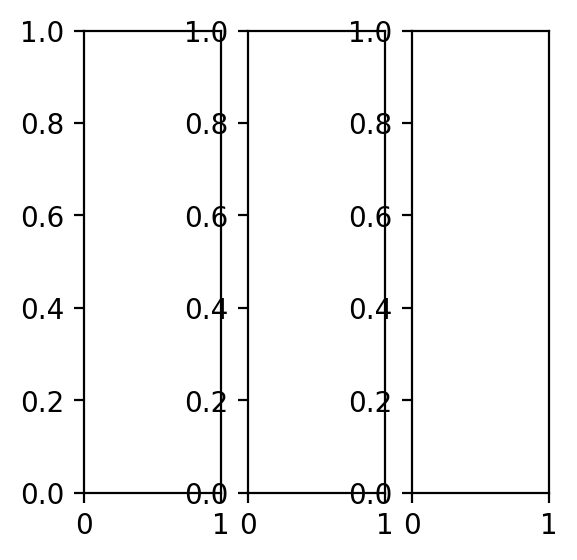

In [42]:
# single 
sm.pl.distPlot(adata, layer='log', markers=['CD45','ECAD','FOXP3'], ncols=3, figsize=(3,3))

We also use bimarker gating to identify a gate

/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered



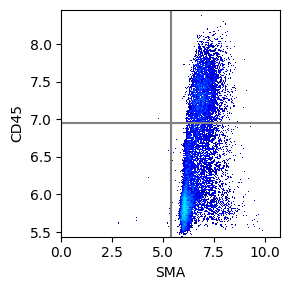

In [46]:
sm.pl.densityPlot2D(adata, markerA='SMA', markerB='CD45', layer='log')


### Step 2: Rescale the data

Here, we input a `manual_gates.csv` file into the gate parameter. This file contains gates determined visually with the help of the `sm.pl.gate_finder` function. For the markers specified in the `manual_gates.csv` file, the function will adjust the data so that cells exhibiting expression levels above the gate threshold are classified as positive for that marker, while those with expression levels below the threshold are deemed negative.

For markers not listed in the `manual_gates.csv` file, the function will employ an automatic approach to identify suitable gates by applying a Gaussian mixture model algorithm to the data.

In [11]:
# Load the manual gates and rescale the data based on the gates
manual_gate = pd.read_csv('/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/manual_gates.csv')
adata = sm.pp.rescale (adata, gate=manual_gate)

Scaling Image exemplar-001--unmicst_cell
Scaling ELANE
Scaling CD57
Scaling CD45
Scaling CD11B
Scaling SMA
Scaling CD16
Scaling ECAD
Scaling FOXP3
Scaling NCAM


### Step 3: Run the phenotyping algorithm

In [13]:
# load the phenotyping workflow
phenotype = pd.read_csv('/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/phenotype_workflow.csv')
# view the table:
phenotype.style.format(na_rep='')

,Unnamed: 0,Unnamed: 1,ELANE,CD57,CD45,CD11B,SMA,CD16,ECAD,FOXP3,NCAM
0,all,ECAD+,,,,,,,pos,,
1,all,Immune,,,pos,,,,,,
2,all,SMA+,,,,,pos,,,,
3,Immune,NK cells,,allpos,,neg,,allpos,,,
4,Immune,Other myeloid cells,,,,pos,,,,,
5,Immune,Treg,,,,,,,,pos,
6,Other myeloid cells,Dendritic cells,,allneg,,,,allneg,,,


As it can be seen from the table above,  

1. The `first column` has to contain the cell that are to be classified.  
2. The `second column` indicates the phenotype a particular cell will be assigned if it satifies the conditions in the row.  
3. `Column three` and onward represent protein markers. If the protein marker is known to be expressed for that cell type, then it is denoted by either `pos`, `allpos`. If the protein marker is known to not express for a cell type it can be denoted by `neg`, `allneg`. If the protein marker is irrelevant or uncertain to express for a cell type, then it is left empty. `anypos` and `anyneg` are options for using a set of markers and if any of the marker is positive or negative, the cell type is denoted accordingly.

**To give users maximum flexibility in identifying desired cell types, we have implemented various classification arguments as described above for strategical classification. They include**

- allpos
- allneg
- anypos
- anyneg
- pos
- neg
  
`pos` : "Pos" looks for cells positive for a given marker. If multiple markers are annotated as `pos`, all must be positive to denote the cell type. For example, a Regulatory T cell can be defined as `CD3+CD4+FOXP3+` by passing `pos` to each marker. If one or more markers don't meet the criteria (e.g. CD4-), the program will classify it as `Likely-Regulatory-T cell`, pending user confirmation. This is useful in cases of technical artifacts or when cell types (such as cancer cells) are defined by marker loss (e.g. T-cell Lymphomas).
  
`neg` : Same as `pos` but looks for negativity of the defined markers. 
  
`allpos` : "Allpos" requires all defined markers to be positive. Unlike `pos`, it doesn't classify cells as `Likely-cellType`, but strictly annotates cells positive for all defined markers.
  
`allneg` : Same as `allpos` but looks for negativity of the defined markers. 
  
`anypos` : "Anypos" requires only one of the defined markers to be positive. For example, to define macrophages, a cell could be designated as such if any of `CD68`, `CD163`, or `CD206` is positive.
  
`anyneg` : Same as `anyneg` but looks for negativity of the defined markers. 

In [14]:
adata = sm.tl.phenotype_cells (adata, phenotype=phenotype, label="phenotype") 

Phenotyping ECAD+
Phenotyping Immune
Phenotyping SMA+
-- Subsetting Immune
Phenotyping NK cells
Phenotyping Other myeloid cells
Phenotyping Treg
-- Subsetting Other myeloid cells
Phenotyping Dendritic cells
Consolidating the phenotypes across all groups


/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [15]:
# Summary of the phenotyping
adata.obs['phenotype'].value_counts()

phenotype
Immune                 4746
ECAD+                  3015
Unknown                2278
SMA+                    602
Treg                    282
Other myeloid cells     193
NK cells                 66
Dendritic cells          19
Name: count, dtype: int64

## Visualisation of the Results

/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/scimap/plotting/heatmap.py:318: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



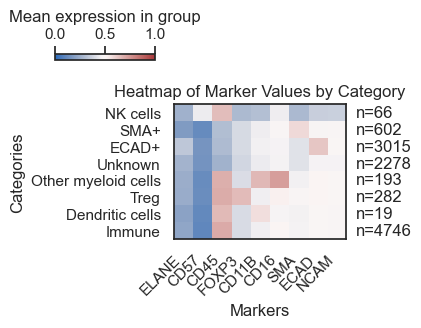

In [21]:
# Heatmap (here values over 0.5 are considered positive as we have scaled the data)
sm.pl.heatmap(adata, groupBy='phenotype', standardScale=None, figsize=(5,3), showPrevalence=True, vmin=0, vmax=1)

In [22]:
# view the phenotype on a UMAP
adata = sm.tl.umap(adata)


/Users/aj/miniconda3/envs/scimap/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not exemplar-001--unmicst_cell_1         Immune
exemplar-001--unmicst_cell_2         Immune
exemplar-001--unmicst_cell_3         Immune
exemplar-001--unmicst_cell_4         Immune
exemplar-001--unmicst_cell_5        Unknown
                                     ...   
exemplar-001--unmicst_cell_11197     Immune
exemplar-001--unmicst_cell_11198     Immune
exemplar-001--unmicst_cell_11199     Immune
exemplar-001--unmicst_cell_11200    Unknown
exemplar-001--unmicst_cell_11201    Unknown
Name: phenotype, Length: 11201, dtype: object

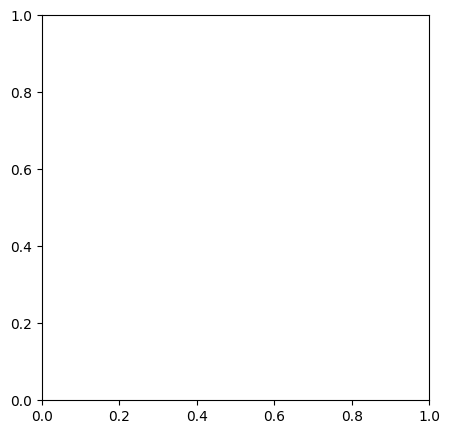

In [24]:
sm.pl.umap(adata, color=['phenotype'])

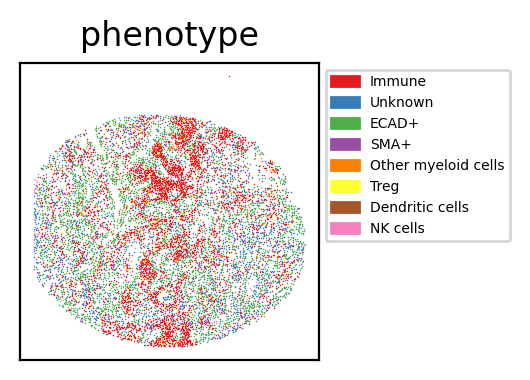

In [31]:
# spatial scatter plot to look at the distribution of cells
sm.pl.spatial_scatterPlot (adata, colorBy = ['phenotype'],figsize=(2.75,2), s=0.3, fontsize=5, catCmap='Set1')

In [33]:
# View the results by overlaying it on the raw image
image_path = '/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/registration/exemplar-001.ome.tif'

# view in napari
sm.pl.image_viewer(image_path=image_path, 
                   adata=adata, 
                   overlay='phenotype', 
                   point_size=10,
                   point_color='white')

# Note that if your AnnotatedData object (adata) includes multiple images, 
# you can use the `subset` parameter to specify the image name found in the `imageid` column, 
# enabling the loading of just that particular image.

### Save Results

In [25]:
# Save the results
adata.write('/Users/aj/Dropbox (Partners HealthCare)/nirmal lab/resources/exemplarData/scimapExampleData/scimapExampleData.h5ad')